In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

In [2]:
import cv2
import pickle
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class TeamClassifier:
    def __init__(self):
        self.team_colors = {
            1: np.array([255, 0, 0]),   # Чиста црвена
            2: np.array([0, 0, 255])    # Чиста плава
        }
        self.player_team_dict = {}
        self.green_thresholds = [
            (30, 50, 50),  # Доња граница за зелену у HSV
            (90, 255, 255)  # Горња граница за зелену у HSV
        ]

    def get_clustering_model(self, image, k=2):
        image_2d = image.reshape(-1, 3)
        kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10)
        kmeans.fit(image_2d)
        return kmeans

    def is_color_green(self, color_hsv):
        lower_green, upper_green = self.green_thresholds
        return cv2.inRange(np.uint8([[color_hsv]]), np.array(lower_green), np.array(upper_green)).any()

    def get_player_color(self, frame, bounding_box):
        image = frame[int(bounding_box[1]):int(bounding_box[3]), int(bounding_box[0]):int(bounding_box[2])]

        # Пребаците слику у HSV простор
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Узмите централни део слике
        h, w, _ = image_hsv.shape
        center_h, center_w = h // 2, w // 2
        offset_h, offset_w = h // 4, w // 4
        central_image_hsv = image_hsv[center_h-offset_h:center_h+offset_h, center_w-offset_w:center_w+offset_w]

        kmeans = self.get_clustering_model(central_image_hsv, k=2)
        cluster_centers = kmeans.cluster_centers_
        labels, counts = np.unique(kmeans.labels_, return_counts=True)

        # Идентификујте кластер који није зелени (позадина)
        non_green_clusters = [cluster for cluster in cluster_centers if not self.is_color_green(cluster)]
        if len(non_green_clusters) > 0:
            dominant_color = non_green_clusters[np.argmax(counts)]
        else:
            dominant_color = cluster_centers[np.argmax(counts)]

        print(f"Extracted player color (HSV): {dominant_color}")

        # Визуелизација кластерисаних боја
        segmented_image_hsv = np.zeros_like(central_image_hsv)
        for i in range(len(cluster_centers)):
            mask = (kmeans.labels_ == i)
            segmented_image_hsv[mask.reshape(central_image_hsv.shape[:2])] = cluster_centers[i]
        segmented_image_bgr = cv2.cvtColor(segmented_image_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(segmented_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title(f'Кластерисане боје играча (HSV)')
        plt.axis('off')
        plt.show()

        # Пребаците доминантну боју назад у RGB простор за даље рачунање
        dominant_color_bgr = cv2.cvtColor(np.uint8([[dominant_color]]), cv2.COLOR_HSV2BGR)[0][0]
        return dominant_color_bgr

    def get_closest_team_color(self, color):
        distances = {team: np.linalg.norm(color - team_color) for team, team_color in self.team_colors.items()}
        print(f"Color distances: {distances}")
        return min(distances, key=distances.get)

    def get_player_team(self, frame, player_bounding_box, player_id):
        player_color = self.get_player_color(frame, player_bounding_box)
        team_id = self.get_closest_team_color(player_color)
        print(f"Player {player_id} assigned to team {team_id} with color {self.team_colors[team_id]}")
        self.player_team_dict[player_id] = team_id

        return team_id

    def assign_team_color(self, frame, player_detections):
        player_colors = []
        for player_detection in player_detections:
            bounding_box = player_detection["bounding_box"]
            player_color = self.get_player_color(frame, bounding_box)
            player_colors.append(player_color)
        
        kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10)
        kmeans.fit(player_colors)

        self.kmeans = kmeans

        self.team_colors[1] = kmeans.cluster_centers_[0]
        self.team_colors[2] = kmeans.cluster_centers_[1]

In [3]:
# Функција за визуализацију сваке детекције играча посебно са екстрактованом бојом и класификацијом у тим
def display_image_with_bboxes(image, player_detections, team_classifier):
    for player_id, detection in player_detections.items():
        bbox = detection['bounding_box']
        print(f"Player {player_id} bounding box: {bbox}")  # Додајте испис за bounding box

        # Осигурајте да су координате bounding box-ова унутар слике
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        height, width, _ = image.shape
        x1 = max(0, min(x1, width))
        x2 = max(0, min(x2, width))
        y1 = max(0, min(y1, height))
        y2 = max(0, min(y2, height))

        team = team_classifier.get_player_team(image, (x1, y1, x2, y2), player_id)
        color = team_classifier.team_colors[team]

        # Исеците слику играча
        player_image = image[y1:y2, x1:x2]
        
        # Нацртајте bounding box на исеченој слици
        cv2.rectangle(player_image, (0, 0), (player_image.shape[1], player_image.shape[0]), color.tolist(), 2)

        # Нацртајте идентификациони број играча
        cv2.putText(player_image, str(player_id), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color.tolist(), 2)

        # Прикажите исечену слику играча
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(player_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Играч {player_id} из тима {team}')
        plt.axis('off')
        plt.show()

In [4]:
# Учитавање специфичног видео фрејма
def load_specific_video_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()  # Учитај специфични фрејм
    cap.release()
    return frame

# Учитавање детекција из кеша
def load_tracks(cache_path):
    with open(cache_path, 'rb') as f:
        tracks = pickle.load(f)
    return tracks

Extracted player color (HSV): [100.43115942 121.86231884 152.50724638]


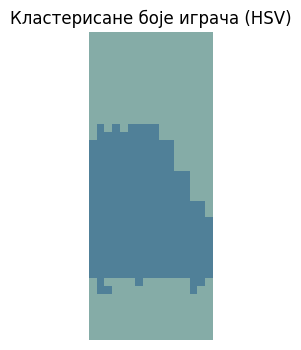

Extracted player color (HSV): [ 61.41139241  39.90295359 167.39451477]


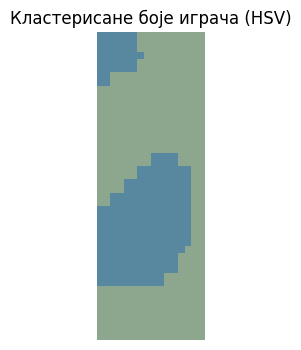

Extracted player color (HSV): [  9.34195402  86.25287356 189.95114943]


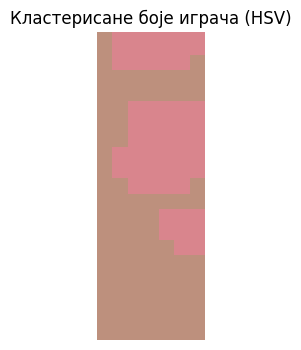

Extracted player color (HSV): [102.13944223 134.98007968 170.69322709]


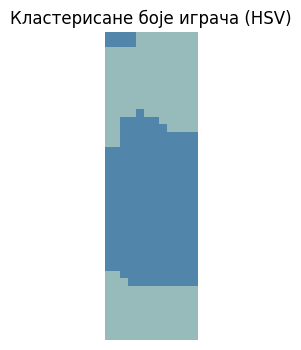

Extracted player color (HSV): [ 74.92937853  47.62429379 154.38983051]


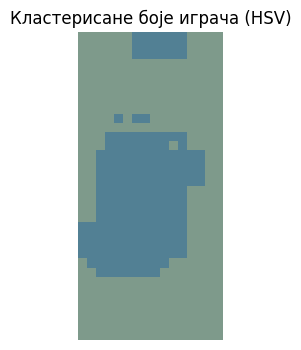

Extracted player color (HSV): [  5.48214286 100.41071429 176.87142857]


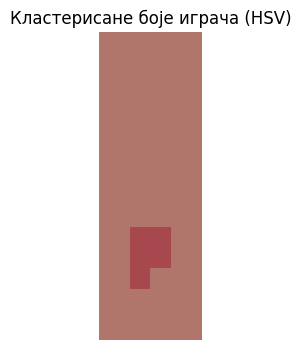

Extracted player color (HSV): [177.16346154 104.92788462 210.21634615]


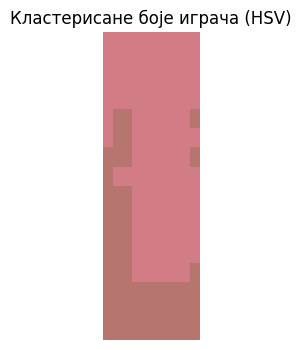

Extracted player color (HSV): [101.71666667 122.35277778 156.01666667]


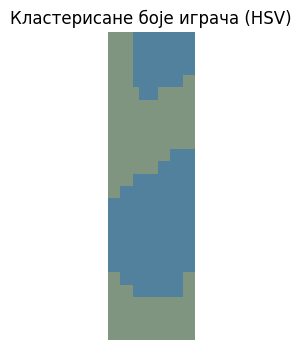

Extracted player color (HSV): [100.00431034  72.06896552 142.95258621]


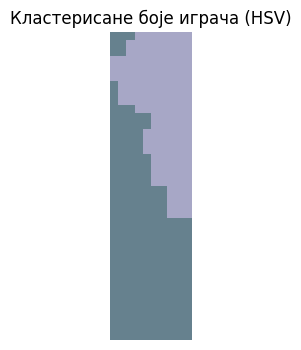

Extracted player color (HSV): [ 16.00902935  58.9537246  194.33860045]


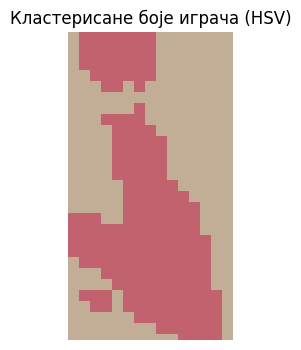

AttributeError: 'list' object has no attribute 'items'

: 

In [5]:
# Претпоставимо да већ имамо учитан видео и детекције играча у одговарајућим променљивим
video_path = '../data/trackertest.mp4'
cache_path = '../cache/tracks_cache.pkl'

frame_number = 13  # Учитајте 13-ти фрејм
frame = load_specific_video_frame(video_path, frame_number)
tracks = load_tracks(cache_path)

# Пример детекција играча (замените са стварним детекцијама из фајла tracks)
player_detections = tracks['players'][frame_number]  # Узмите детекције за 13-ти фрејм

# Уверите се да је player_detections листа
if not isinstance(player_detections, list):
    player_detections = list(player_detections.values())

# Креирајте класификатор тимова
team_classifier = TeamClassifier()

# Доделите тимске боје на основу детекција играча
team_classifier.assign_team_color(frame, player_detections)

# Прикажите сваку детекцију играча посебно са екстрактованом бојом и класификацијом у тим
display_image_with_bboxes(frame, player_detections, team_classifier)